Exploring the output files generated by the Salish Sea Atlantis Model

In [1]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

## Define scenario and control files

In [2]:
# Read in salish sea atlantis output files.
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber_discharge_2019_02_control/outputSalishSea.nc"
scenario1_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber_discharge_2019_02/outputSalishSea.nc"
scenario2_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber_discharge_2019-2023_02/outputSalishSea.nc"
scenario3_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber_discharge_2019-2029_02/outputSalishSea.nc"

control = xr.open_dataset(str(control_file), decode_cf=True)
scenario1 = xr.open_dataset(str(scenario1_file), decode_cf=True)
scenario2 = xr.open_dataset(str(scenario2_file), decode_cf=True)
scenario3 = xr.open_dataset(str(scenario3_file), decode_cf=True)

t = np.ma.filled(scenario1.variables['t'], np.nan)

# start and end time of data display, after burn-in
start = 101
end = t.size-1

time = t[start:end]

spill_start = np.datetime64('2019-01-01')
spill_end = np.datetime64('2019-12-31')


## Dictionary of ecological groups

aged_groups = {
    'sharks','birds','mammals','fish','salmon'
}

pelagic_groups = {
    'plankton','bacteria','sharks','birds','mammals','fish','salmon'
}

benthic_groups = {
    'benthos','shellfish'
}

In [29]:
cohorts = {
    'Benthopelagic':10, 'Small_Demersal_fish':10, 'Small_Flatfish':10, 'Small_pelagic_fish':7,
    'Chinook_salmon':5, 'Chum_salmon':5, 'Coho_salmon':5,'Pink_salmon':5, 'Sockeye_salmon':5, 
    'Other_salmonids':8,'Hatchery_Chinook_salmon':3,'Hatchery_Coho_salmon':3,'Hatchery_Sockeye_salmon':3,
    'Dogfish':10,'Ratfish':10,'Rockfish':10,'Sixgill':10,'Hake':10,
    'Harbor_porpoise':10, 'Harbor_seals':10,'Humpback_whales':10,
    'Large_Demersal_fish':10, 'Large_Flatfish' :10,'Lingcod' :10,
    'Orcas_resident':10, 'Orcas_transient':10,
    'Pacific_herring':10,'Pollock':10,'Sandlance':7, 
    'Seabird_gulls':10, 'Seabirds':10,'Sealions':10,'Skates':10,
}

sharks = {
    'dogfish':'Dogfish','ratfish':'Ratfish', 'sixgill':'Sixgill', 'skates':'Skates',
}

birds = {
    'seagulls':'Seabird_gulls', 'other seabirds':'Seabirds',
}

mammals = {
    'porpoises':'Harbor_porpoise', 'seals':'Harbor_seals', 'humpbacks':'Humpback_whales','sealions':'Sealions',
    'resident orcas':'Orcas_resident', 'transient orcas':'Orcas_transient',
}
    
fish = {
    'benthopelagic':'Benthopelagic', 'small pelagic':'Small_pelagic_fish', 'small demersal':'Small_Demersal_fish', 
    'large demersal':'Large_Demersal_fish', 'small flatfish':'Small_Flatfish', 'large flatfish':'Large_Flatfish', 'hake':'Hake',
    'lingcod':'Lingcod', 'pollock':'Pollock', 'sandlance':'Sandlance', 'rockfish':'Rockfish', 'pacific herring':'Pacific_herring',
}

salmon = {
    'Chinook':'Chinook_salmon', 'Chum':'Chum_salmon', 'Coho':'Coho_salmon','Pink':'Pink_salmon', 'Sockeye':'Sockeye_salmon', 
    'Hatchery Chinook':'Hatchery_Chinook_salmon','Hatchery Coho':'Hatchery_Coho_salmon','Hatchery Sockeye':'Hatchery_Sockeye_salmon', 
    'Other':'Other_salmonids'
}

benthos = {
    'benthic carnivores':'Benthic_Carniv', 'benthic grazers':'Benthic_grazer', 'deposit feeders':'Deposit_Feeder',
    'filter feeders': 'Filter_feeder', 'macrobenthos':'Macrobenthos', 'meiobenthos':'Meiobenth', 
    'macroalgae':'Macroalgae', 'seagrass':'Seagrass', 'sponges':'Sponges', 
}
    
shellfish = {
    'bivalves':'Bivalves', 'crabs':'Crabs', 'dungeness crabs':'Dungeness_crabs',
}

plankton = {
    'carnivorous zooplankton':'Carniv_Zoo', 'gelatinous zooplantkon':'Gelat_Zoo', #'microzooplankton':'MicroZoo',
    'macozooplankton':'Zoo', 'diatoms':'Diatom', 'picophytoplankton':'PicoPhytopl', 'squid':'Squid', 'prawn': 'Prawn',
}

bacteria = {
    'labile detritus':'Lab_Det', 'refractory detritus':'Ref_Det', 
    'pelagic bacteria':'Pelag_Bact','sedimentary bacteria': 'Sed_Bact'
}

## Group plotting functions

- plot_benthos(group)
- plot_pelagic(group)
- plot_cohorts(group)

In [12]:
def plot_benthos(group, scenario): # benthos, shellfish

    # Plot variables
    label_size = 11
    font_size = 12
    line_width = 2
    y_min = 0.5
    y_max = 1.5

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of benthic groups across all boxes in Salish Sea Atlantis', fontsize = font_size)
    #ax.set_ylim([0.8, 1.2])

    for species in group:
        benthic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,:], np.nan) # tonnes
        benthic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,:], np.nan)
        ratio = benthic_oiled.sum(axis=1) / benthic_control.sum(axis=1) 
        control_ratio = benthic_control.sum(axis=1)  / benthic_control.sum(axis=1) 
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(group, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)
    ax.plot([spill_start, spill_start], [y_min, y_max], 'r', alpha=0.1)
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)
    return fig, ax

In [7]:
def plot_benthos_box(group, scenario, box_number): # benthos, shellfish

    # Plot variables
    label_size = 11
    font_size = 12
    line_width = 2
    y_min = 0.5
    y_max = 1.5

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of benthic groups across all boxes in Salish Sea Atlantis', fontsize = font_size)
    ax.set_ylim([0.1, 2])

    for species in group:
        benthic_oiled = scenario.variables[group[species] + '_N'][start:end,box_number] # tonnes
        benthic_control = control.variables[group[species] + '_N'][start:end,box_number]
        ratio = benthic_oiled / benthic_control
        control_ratio = benthic_control / benthic_control
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(group, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)
    ax.plot([spill_start, spill_start], [y_min, y_max], 'r', alpha=0.1)
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)
    return fig, ax

In [77]:
def plot_pelagic(group, scenario): #bacteria, plankton
    
    # Plot variables
    label_size = 11
    font_size = 12
    line_width = 2
    #y_min = 0.5
    #y_max = 1.5

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of pelagic groups across all boxes in Salish Sea Atlantis', fontsize = font_size)
    #ax.set_ylim([y_min, y_max])

    for species in group:
        pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,:,:], np.nan) # tonnes
        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,:,:], np.nan)
        p_oiled = pelagic_oiled.sum(axis=1)
        p_control = pelagic_control.sum(axis=1)
        ratio = p_oiled.sum(axis=1) / p_control.sum(axis=1) 
        control_ratio = p_control.sum(axis=1) / p_control.sum(axis=1)
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(group, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)
    #ax.plot([spill_start, spill_start], [y_min, y_max], 'r', alpha=0.1)
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)
    return fig, ax

In [22]:
def plot_pelagic_box(group, scenario, box_number): #bacteria, plankton
    
    # Plot variables
    label_size = 11
    font_size = 12
    line_width = 2
    y_min = 0.1
    y_max = 2

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of pelagic groups in Salish Sea Atlantis box ' + str(box_number), fontsize = font_size)
    ax.set_ylim([y_min, y_max])

    for species in group:
        pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,box_number,:], np.nan) # tonnes
        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,box_number,:], np.nan)
        p_oiled = pelagic_oiled.sum(axis=1)
        p_control = pelagic_control.sum(axis=1)
        ratio = p_oiled / p_control
        control_ratio = p_control / p_control
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(group, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)
    ax.plot([spill_start, spill_start], [y_min, y_max], 'r', alpha=0.1)
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)
    return fig, ax

In [61]:
def plot_cohorts(group, scenario):

    # Plot variables
    label_size = 11
    font_size = 12
    line_width = 2
    y_min = 0.5
    y_max = 1.5

    fig, ax = plt.subplots(3,1, figsize = (14,9), sharex='all')
    ax[0].set_title(group + ' Numbers', fontsize = font_size)
    ax[0].set_ylabel('scenario : control')
    ax[0].tick_params(labelsize=label_size)
    ax[0].set_ylim([y_min, y_max])

    ax[1].set_title(group + ' Structural Nitrogen (bone size)', fontsize = font_size)
    ax[1].set_ylabel('scenario : control')
    ax[1].tick_params(labelsize=label_size)
    ax[1].set_ylim([y_min, y_max])

    ax[2].set_title(group + ' Reserve Nitrogen (fatty tissue)', fontsize = font_size)
    ax[2].set_ylabel('scenario : control')
    ax[2].tick_params(labelsize=label_size)
    ax[2].set_ylim([y_min, y_max])

    numCohorts = cohorts[group]
    cohort_names = []

    for cohort_num in range (1, numCohorts+1):

        new_species = group + str(cohort_num)
        cohort_names.append(cohort_num)
    
        o1_numbers = np.ma.filled(scenario.variables[new_species + '_Nums'][:,:,:], np.nan)
        o1_structuralN = np.ma.filled(scenario.variables[new_species +'_StructN'][:,:,:], np.nan)
        o1_reservedN = np.ma.filled(scenario.variables[new_species +'_ResN'][:,:,:], np.nan)

        c1_numbers = np.ma.filled(control.variables[new_species + '_Nums'][:,:,:], np.nan)
        c1_structuralN = np.ma.filled(control.variables[new_species +'_StructN'][:,:,:], np.nan)
        c1_reservedN = np.ma.filled(control.variables[new_species +'_ResN'][:,:,:], np.nan)

        o2_numbers = o1_numbers.sum(axis=2)
        o2_structuralN = o1_structuralN.sum(axis=2)
        o2_reservedN = o1_reservedN.sum(axis=2)

        c2_numbers = c1_numbers.sum(axis=2)
        c2_structuralN = c1_structuralN.sum(axis=2)
        c2_reservedN = c1_reservedN.sum(axis=2)

        numbers = o2_numbers.sum(axis=1) / c2_numbers.sum(axis=1)
        structuralN = o2_structuralN.sum(axis=1) / c2_structuralN.sum(axis=1)
        reservedN = o2_reservedN.sum(axis=1) / c2_reservedN.sum(axis=1)
        control_ratio = c2_reservedN.sum(axis=1) / c2_reservedN.sum(axis=1)

        ax[0].plot(time, numbers[start:end], linewidth = line_width)
        ax[1].plot(time, structuralN[start:end],linewidth = line_width)
        ax[2].plot(time, reservedN[start:end],linewidth = line_width)

    ax[0].legend(cohort_names, loc='center left')
    ax[0].plot(time, control_ratio[start:end], 'k',linewidth = 2)
    ax[0].plot([spill_start, spill_start], [y_min, y_max], 'r', alpha=0.1)
    #ax[0].plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)

        
    ax[1].plot(time, control_ratio[start:end], 'k',linewidth = 2)
    ax[1].plot([spill_start, spill_start], [y_min, y_max], 'r', alpha=0.1)
    #ax[1].plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)

        
    ax[2].plot(time, control_ratio[start:end], 'k',linewidth = 2)
    ax[2].plot([spill_start, spill_start], [y_min, y_max], 'r', alpha=0.1)
    #ax[2].plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)

    return fig, ax
    

In [16]:
def plot_pelagic_pah_box(group, pah, scenario, box_number):

# Plot variables
    label_size = 11
    font_size = 12
    line_width = 2

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('mgPAH')
    ax.set_title(pah + 'in pelagic groups in Salish Sea Atlantis box ' + str(box_number), fontsize = font_size)

    for species in group:
        pelagic_oiled = scenario.variables[group[species] + '_' + pah][start:end,box_number,:]
        p_oiled = pelagic_oiled.sum(axis=1)
        ax.plot(time, p_oiled, linewidth = 2)
    
    ax.legend(group, loc='center left')
    return fig, ax

## Plotting group ratios

### Pelagic species

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

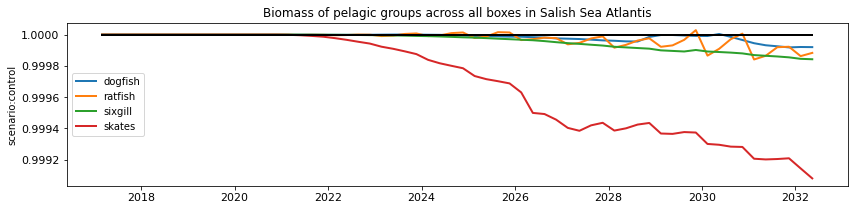

In [81]:
plot_pelagic(sharks, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

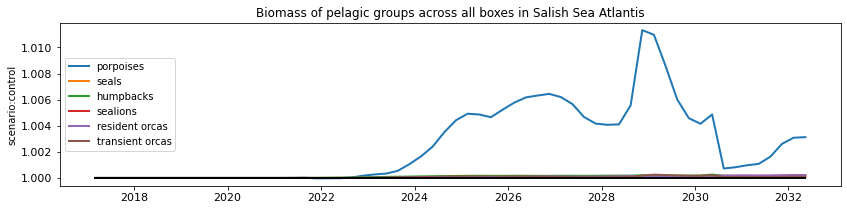

In [80]:
plot_pelagic(mammals, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

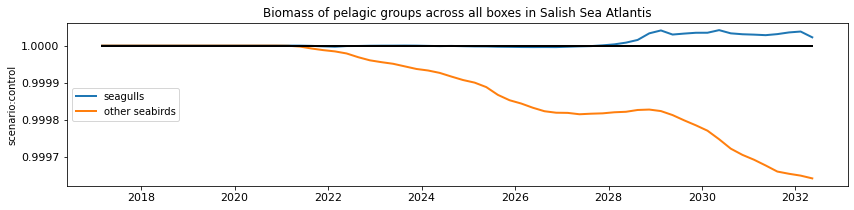

In [79]:
plot_pelagic(birds, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

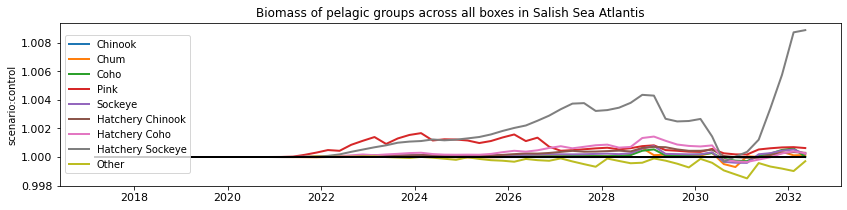

In [78]:
plot_pelagic(salmon, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

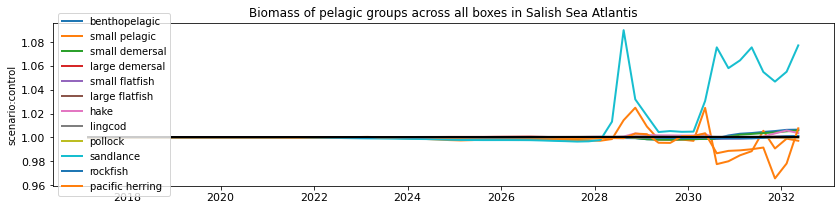

In [82]:
plot_pelagic(fish, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

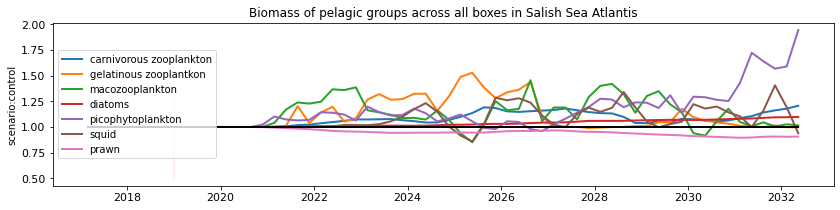

In [70]:
plot_pelagic(plankton, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

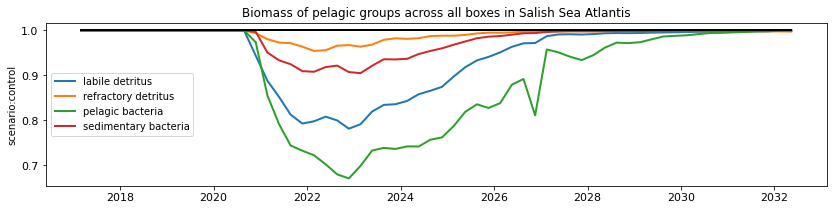

In [83]:
plot_pelagic(bacteria, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups in Salish Sea Atlantis box 62'}, ylabel='scenario:control'>)

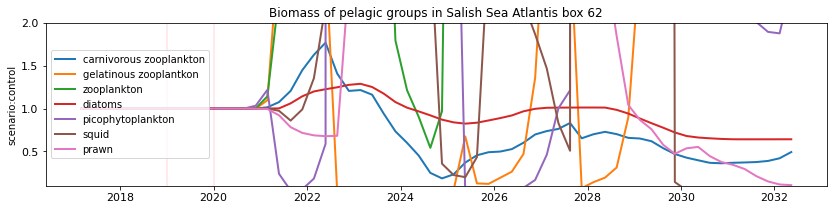

In [13]:
plot_pelagic_box(plankton, 62)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups in Salish Sea Atlantis box 62'}, ylabel='scenario:control'>)

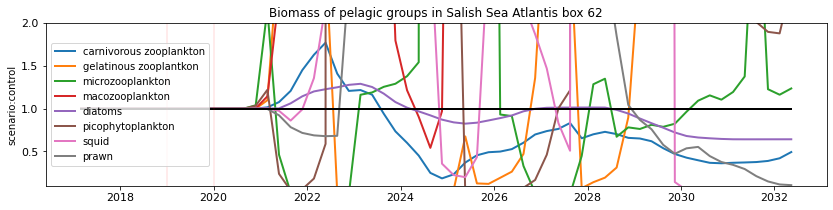

In [19]:
plot_pelagic_box(plankton, scenario1, 62)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups in Salish Sea Atlantis box 62'}, ylabel='scenario:control'>)

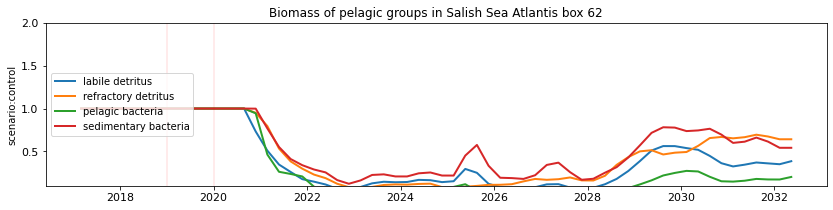

In [14]:
plot_pelagic_box(bacteria, 62)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups in Salish Sea Atlantis box 62'}, ylabel='scenario:control'>)

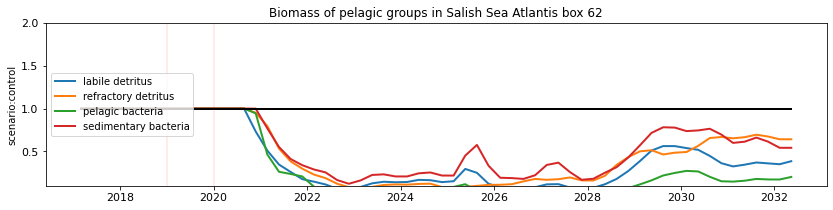

In [20]:
plot_pelagic_box(bacteria, scenario1, 62)

### Benthic species

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of benthic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

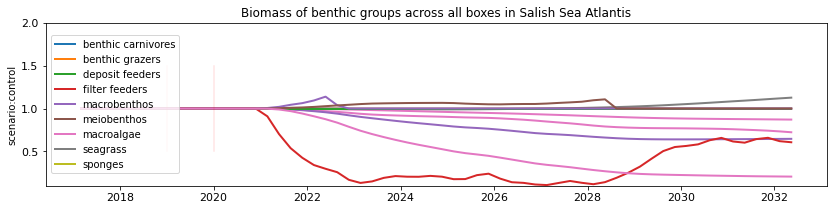

In [24]:
plot_benthos_box(benthos, 62)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of benthic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

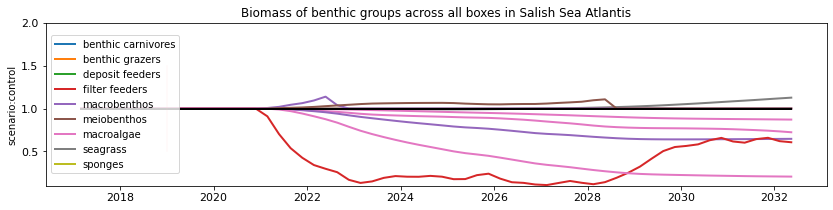

In [8]:
plot_benthos_box(benthos, scenario1, 62)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of benthic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

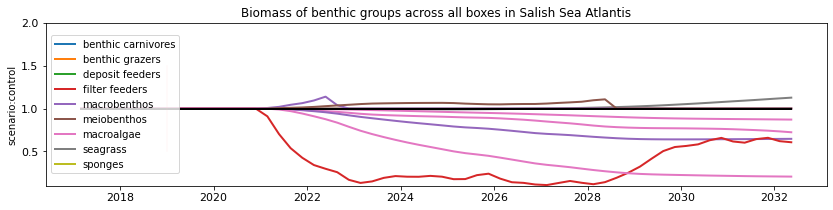

In [9]:
plot_benthos_box(benthos, scenario2, 62)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of benthic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

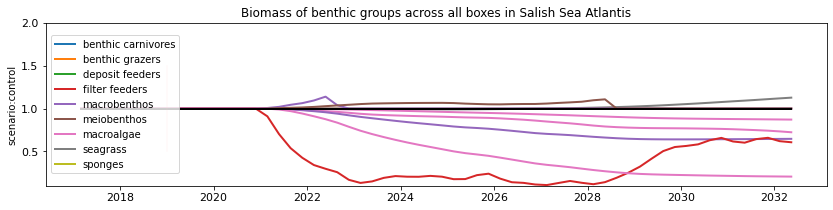

In [10]:
plot_benthos_box(benthos, scenario3, 62)

### Pelagic cohorts

(<Figure size 1008x648 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Numbers - all cohorts'}, ylabel='scenario : control'>,
        <AxesSubplot:title={'center':'Structural Nitrogen (bone size) - all cohorts'}, ylabel='scenario : control'>,
        <AxesSubplot:title={'center':'Reserve Nitrogen (fatty tissue) - all cohorts'}, ylabel='scenario : control'>],
       dtype=object))

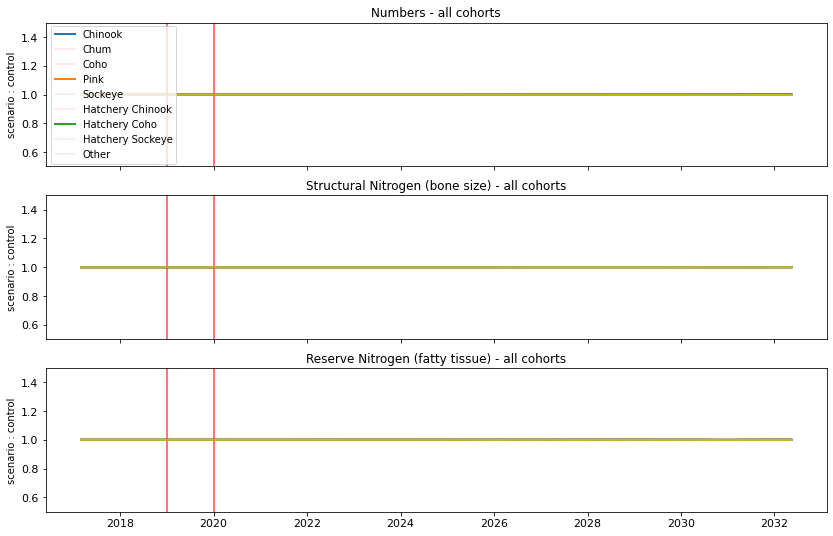

In [72]:
plot_cohorts(salmon)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

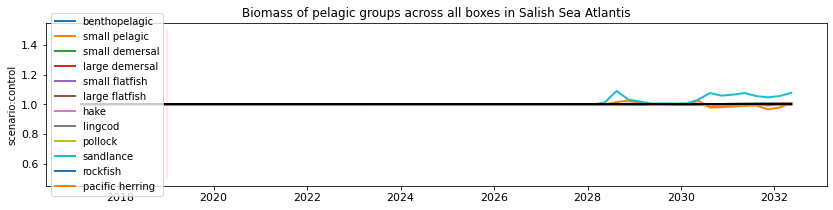

(<Figure size 1008x648 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Pacific_herring Numbers'}, ylabel='scenario : control'>,
        <AxesSubplot:title={'center':'Pacific_herring Structural Nitrogen (bone size)'}, ylabel='scenario : control'>,
        <AxesSubplot:title={'center':'Pacific_herring Reserve Nitrogen (fatty tissue)'}, ylabel='scenario : control'>],
       dtype=object))

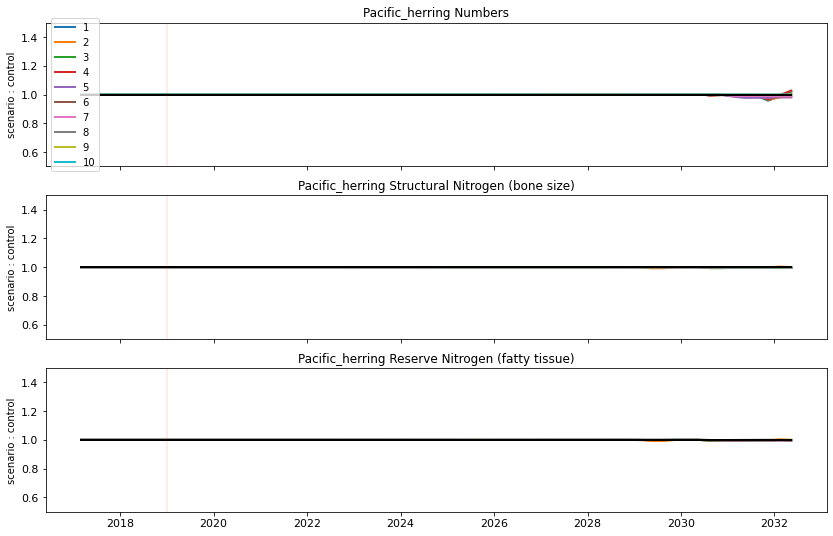

In [64]:
plot_cohorts('Pacific_herring', scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

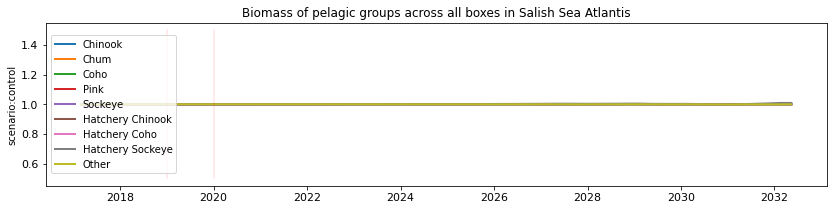

In [73]:
plot_pelagic(salmon)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

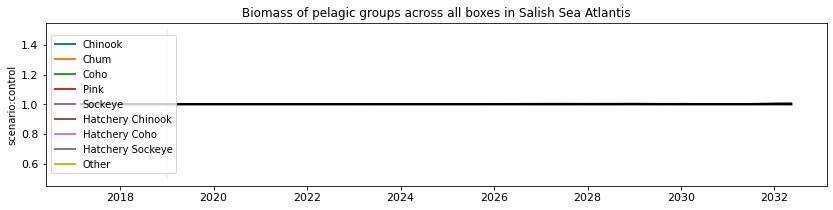

In [25]:
plot_pelagic(salmon, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

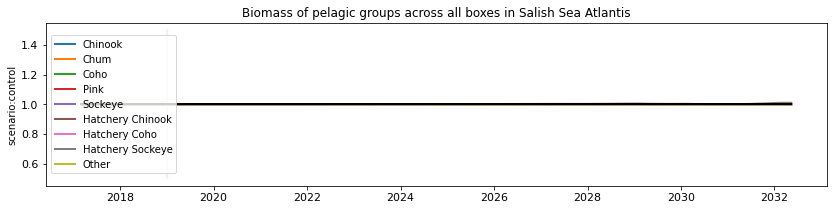

In [26]:
plot_pelagic(salmon, scenario2)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

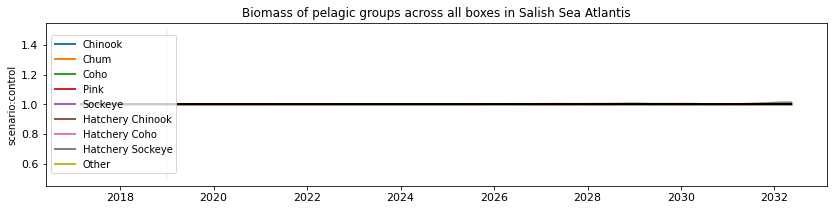

In [27]:
plot_pelagic(salmon, scenario3)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

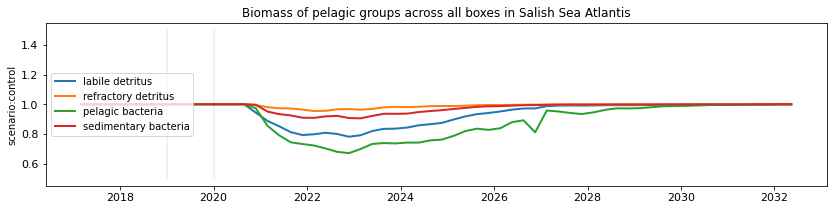

In [74]:
plot_pelagic(bacteria)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

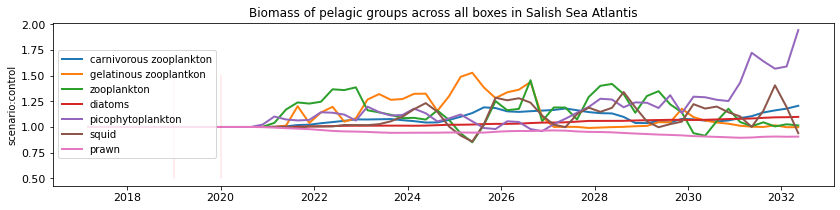

In [75]:
plot_pelagic(plankton)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

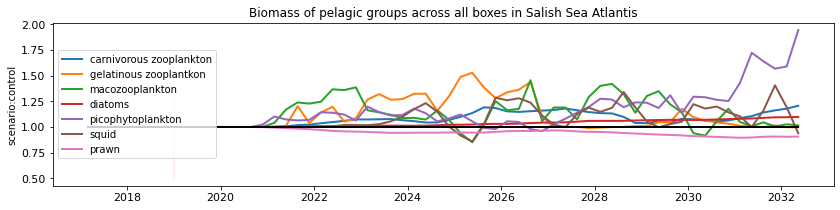

In [30]:
plot_pelagic(plankton, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

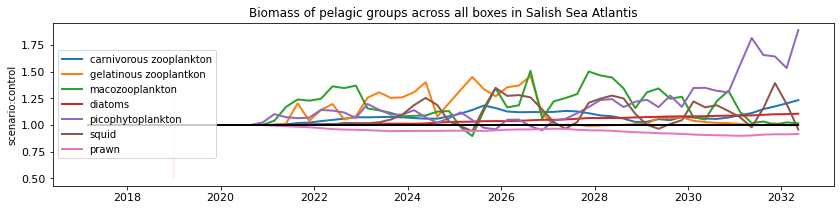

In [31]:
plot_pelagic(plankton, scenario2)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of benthic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

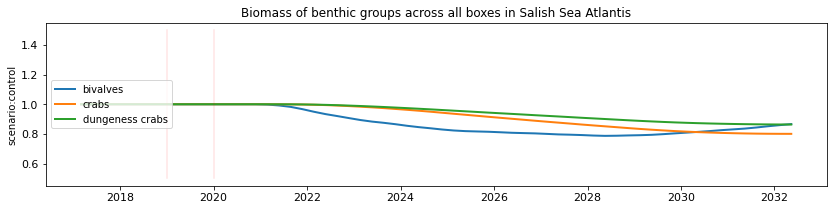

In [76]:
plot_benthos(shellfish)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of benthic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

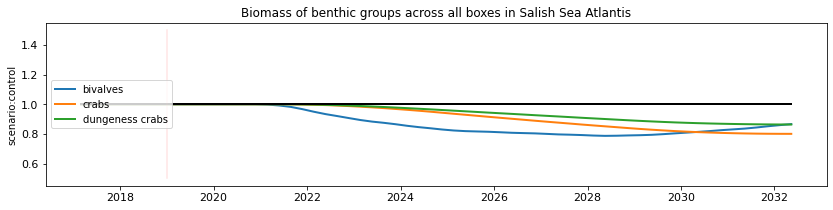

In [32]:
plot_benthos(shellfish, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of benthic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

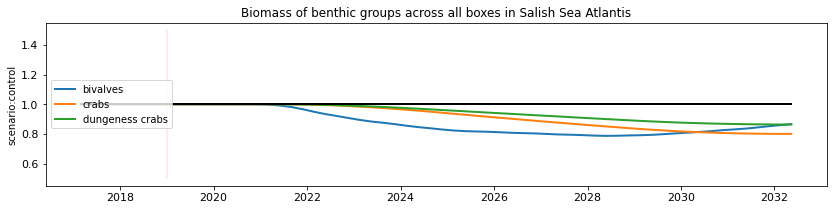

In [33]:
plot_benthos(shellfish, scenario2)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of benthic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

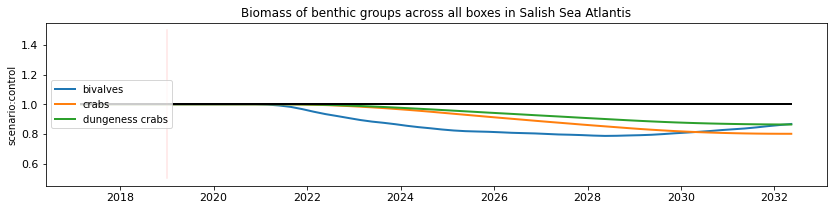

In [34]:
plot_benthos(shellfish, scenario3)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of benthic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

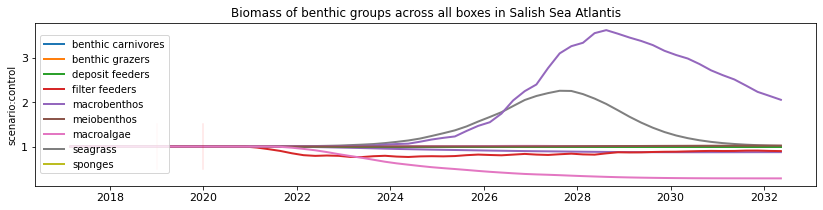

In [77]:
plot_benthos(benthos)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of benthic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

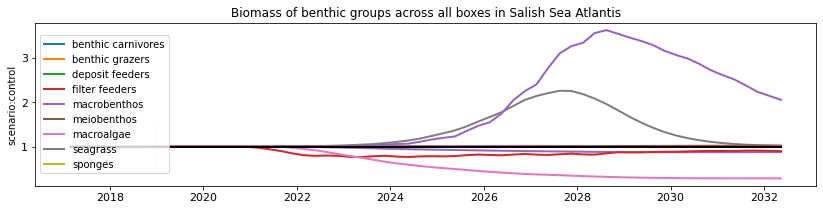

In [35]:
plot_benthos(benthos, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of benthic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

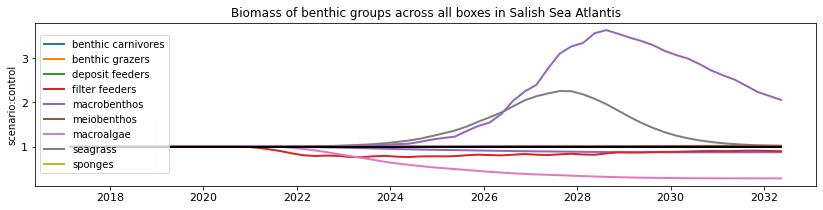

In [36]:
plot_benthos(benthos, scenario2)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of benthic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

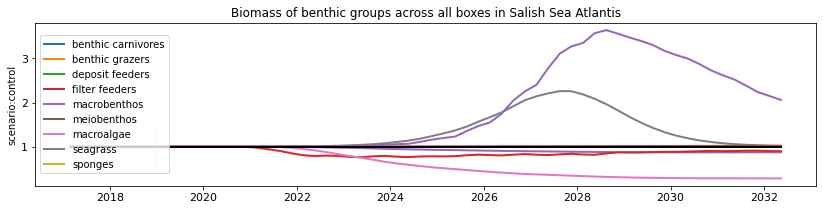

In [37]:
plot_benthos(benthos, scenario3)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

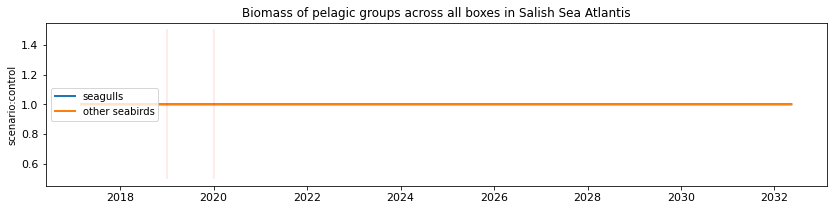

In [78]:
plot_pelagic(birds)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

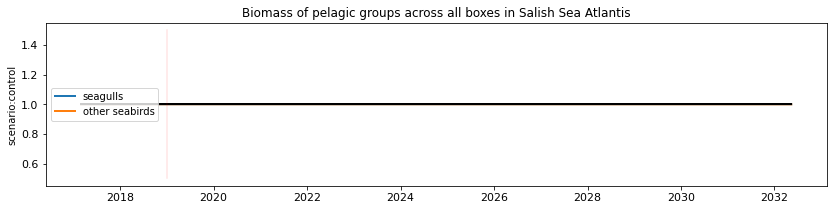

In [38]:
plot_pelagic(birds, scenario1)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

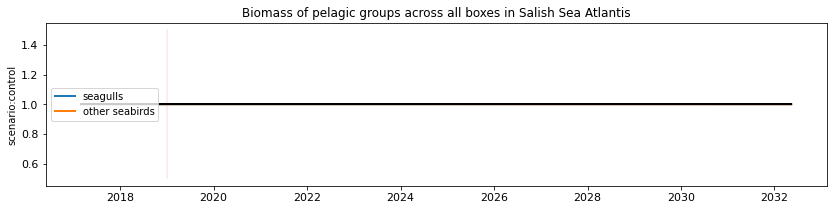

In [39]:
plot_pelagic(birds, scenario2)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Biomass of pelagic groups across all boxes in Salish Sea Atlantis'}, ylabel='scenario:control'>)

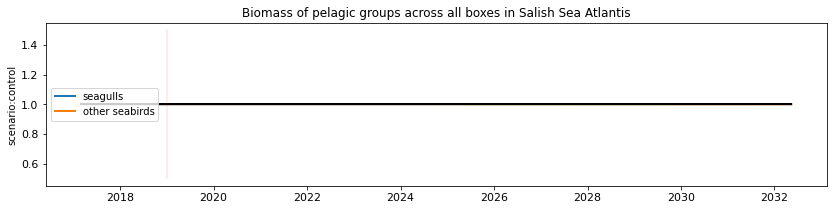

In [40]:
plot_pelagic(birds, scenario3)

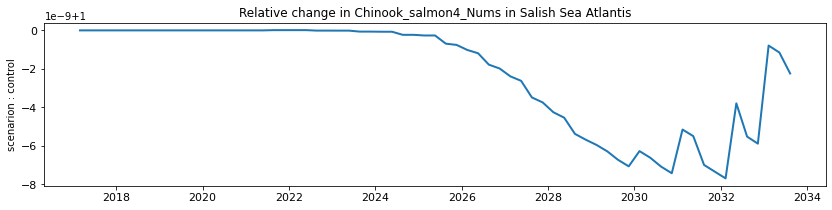

In [125]:
label_size = 11
font_size = 12
line_width = 2

param_oiled = scenario1.sum(axis=1)    #  [t,b]
param_control = control.sum(axis=1)
ratio = param_oiled.sum(axis=1) / param_control.sum(axis=1)

fig, ax = plt.subplots(figsize = (14,3))
ax.plot(time, ratio, linewidth = 2) 
ax.set_title('Relative change in ' + parameter + ' in Salish Sea Atlantis', fontsize = font_size)
ax.set_ylabel('scenarion : control')
ax.tick_params(labelsize=label_size)
#ax.legend(('scrubber discharge', 'control'), loc='best')

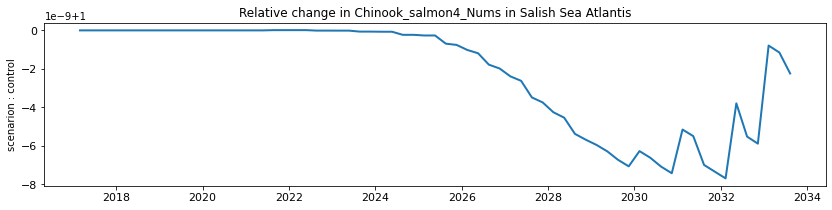

In [ ]:
label_size = 11
font_size = 12
line_width = 2

param_oiled = scenario1.sum(axis=1)    #  [t,b]
param_control = control.sum(axis=1)
ratio = param_oiled.sum(axis=1) / param_control.sum(axis=1)

fig, ax = plt.subplots(figsize = (14,3))
ax.plot(time, ratio, linewidth = 2) 
ax.set_title('Relative change in ' + parameter + ' in Salish Sea Atlantis', fontsize = font_size)
ax.set_ylabel('scenarion : control')
ax.tick_params(labelsize=label_size)
#ax.legend(('scrubber discharge', 'control'), loc='best')

## Exploring individual parameters inside individual boxes

Text(0, 0.5, 'Bivalves')

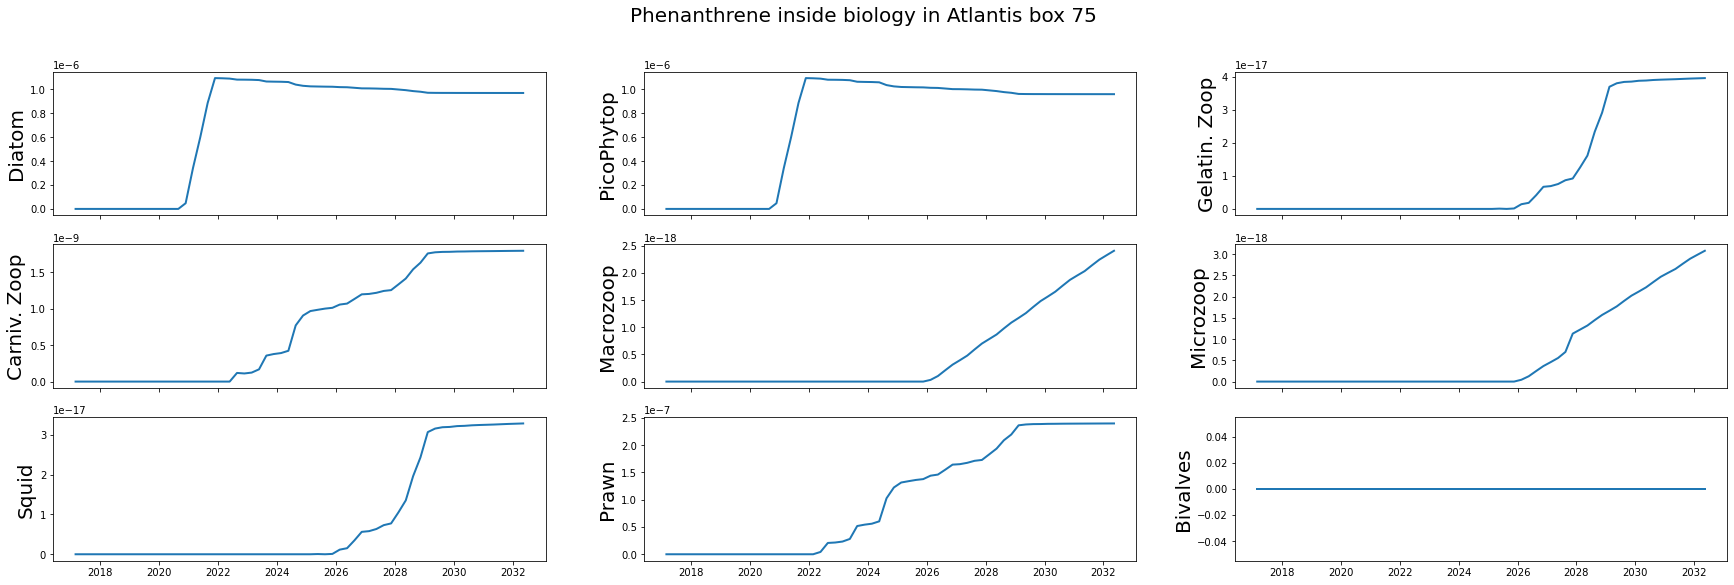

In [26]:
#Other Parameters

parameter = "Phenanthrene" #Phenanthrene Pyrene Benzo
box = 75
data = scenario

diatoms = np.ma.filled(data.variables["Diatom_"+parameter][:,box], np.nan)
picos = np.ma.filled(data.variables["PicoPhytopl_"+parameter][:,box], np.nan)
gel_zoo = np.ma.filled(data.variables["Gelat_Zoo_"+parameter][:,box], np.nan)
carn_zoo = np.ma.filled(data.variables["Carniv_Zoo_"+parameter][:,box], np.nan)
macrozoo = np.ma.filled(data.variables["Zoo_"+parameter][:,box], np.nan)
microzoo = np.ma.filled(data.variables["MicroZoo_"+parameter][:,box], np.nan)
squid = np.ma.filled(data.variables["Squid_"+parameter][:,box], np.nan)
prawn = np.ma.filled(data.variables["Prawn_"+parameter][:,box], np.nan)
bivalves = np.ma.filled(data.variables["Bivalves_"+parameter][:,box], np.nan)
#param_control = np.ma.filled(control.variables[parameter][:,box], np.nan)

font_size = 20

fig, ax = plt.subplots(3,3, figsize = (30,9), sharex=True)
fig.suptitle(parameter + ' inside biology in Atlantis box ' + str(box), fontsize = 20)

ax[0, 0].plot(time, diatoms.sum(axis=1)[start:end], linewidth = 2) #control_time, param_control, 
ax[0, 0].set_ylabel('Diatom', fontsize = font_size)
#ax.legend(('with oil', 'without oil'), loc='lower left')

ax[0, 1].plot(time, picos.sum(axis=1)[start:end], linewidth = 2) #control_time, param_control, 
ax[0, 1].set_ylabel('PicoPhytop', fontsize = font_size)

ax[0, 2].plot(time, gel_zoo.sum(axis=1)[start:end], linewidth = 2) #control_time, param_control, 
ax[0, 2].set_ylabel('Gelatin. Zoop', fontsize = font_size)

ax[1, 0].plot(time, carn_zoo.sum(axis=1)[start:end], linewidth = 2) #control_time, param_control, 
ax[1, 0].set_ylabel('Carniv. Zoop', fontsize = font_size)

ax[1, 1].plot(time, macrozoo.sum(axis=1)[start:end], linewidth = 2) #control_time, param_control, 
ax[1, 1].set_ylabel('Macrozoop', fontsize = font_size)

ax[1, 2].plot(time, microzoo.sum(axis=1)[start:end], linewidth = 2) #control_time, param_control, 
ax[1, 2].set_ylabel('Microzoop', fontsize = font_size)

ax[2, 0].plot(time, squid.sum(axis=1)[start:end], linewidth = 2) #control_time, param_control, 
ax[2, 0].set_ylabel('Squid', fontsize = font_size)

ax[2, 1].plot(time, prawn.sum(axis=1)[start:end], linewidth = 2) #control_time, param_control, 
ax[2, 1].set_ylabel('Prawn', fontsize = font_size)

ax[2, 2].plot(time, bivalves[start:end], linewidth = 2) #control_time, param_control, 
ax[2, 2].set_ylabel('Bivalves', fontsize = font_size)

(<Figure size 1008x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Phenanthrenein pelagic groups in Salish Sea Atlantis box 75'}, ylabel='mgPAH'>)

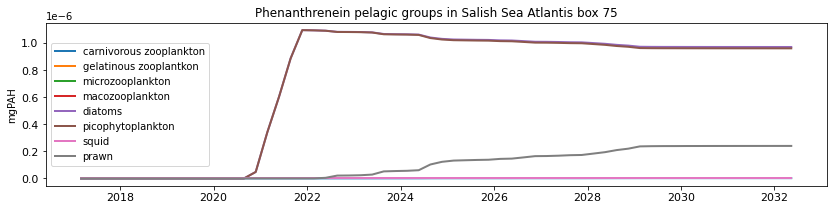

In [39]:
plot_pelagic_pah_box(plankton, 'Phenanthrene', 75) 

## Experimenting with examining contaminant simulation vs the control

### Age-structured functions

In [14]:
# Age-structured species
cohorts = {
    'Benthopelagic':10, 'Small_Demersal_fish':10, 'Small_Flatfish':10, 'Small_pelagic_fish':7,
    'Chinook_salmon':5, 'Chum_salmon':5, 'Coho_salmon':5,'Pink_salmon':5, 'Sockeye_salmon':5, 
    'Other_salmonids':8,'Hatchery_Chinook_salmon':3,'Hatchery_Coho_salmon':3,'Hatchery_Sockeye_salmon':3,
    'Dogfish':10,'Ratfish':10,'Rockfish':10,'Sixgill':10,'Hake':10,
    'Harbor_porpoise':10, 'Harbor_seals':10,'Humpback_whales':10,
    'Large_Demersal_fish':10, 'Large_Flatfish' :10,'Lingcod' :10,
    'Orcas_resident':10, 'Orcas_transient':10,
    'Pacific_herring':10,'Pollock':10,'Sandlance':7, 
    'Seabird_gulls':10, 'Seabirds':10,'Sealions':10,'Skates':10,
 }

In [12]:

def parse_cohorts_biomass_size(scenario, control, species_name):

    # Age-structured species
    cohorts = {
    'Benthopelagic':10, 'Small_Demersal_fish':10, 'Small_Flatfish':10, 'Small_pelagic_fish':7,
    'Chinook_salmon':5, 'Chum_salmon':5, 'Coho_salmon':5,'Pink_salmon':5, 'Sockeye_salmon':5, 
    'Other_salmonids':8,'Hatchery_Chinook_salmon':3,'Hatchery_Coho_salmon':3,'Hatchery_Sockeye_salmon':3,
    'Dogfish':10,'Ratfish':10,'Rockfish':10,'Sixgill':10,'Hake':10,
    'Harbor_porpoise':10, 'Harbor_seals':10,'Humpback_whales':10,
    'Large_Demersal_fish':10, 'Large_Flatfish' :10,'Lingcod' :10,
    'Orcas_resident':10, 'Orcas_transient':10,
    'Pacific_herring':10,'Pollock':10,'Sandlance':7, 
    'Seabird_gulls':10, 'Seabirds':10,'Sealions':10,'Skates':10,
    }
    
    numCohorts = cohorts[species_name]

    scenario_numbers = np.ma.zeros((scenario.variables[species_name + '1_Nums'].shape),dtype = np.int32)
    scenario_structuralN = np.ma.zeros((scenario.variables[species_name + '1_StructN'].shape),dtype = np.int32)
    scenario_reservedN = np.ma.zeros((scenario.variables[species_name + '1_ResN'].shape),dtype = np.int32)

    control_numbers = np.ma.zeros((control.variables[species_name + '1_Nums'].shape),dtype = np.int32)
    control_structuralN = np.ma.zeros((control.variables[species_name + '1_StructN'].shape),dtype = np.int32)
    control_reservedN = np.ma.zeros((control.variables[species_name + '1_ResN'].shape),dtype = np.int32)

    for cohort in range (1, numCohorts+1):

        species = species_name + str(cohort)
        
        scenario_numbers = scenario_numbers + np.ma.filled(scenario.variables[species + '_Nums'][:,:,:], np.nan)
        scenario_structuralN = scenario_structuralN + np.ma.filled(scenario.variables[species +'_StructN'][:,:,:], np.nan)
        scenario_reservedN = scenario_reservedN + np.ma.filled(scenario.variables[species +'_ResN'][:,:,:], np.nan)

        control_numbers = control_numbers + np.ma.filled(control.variables[species + '_Nums'][:,:,:], np.nan)
        control_structuralN = control_structuralN + np.ma.filled(control.variables[species +'_StructN'][:,:,:], np.nan)
        control_reservedN = control_reservedN + np.ma.filled(control.variables[species +'_ResN'][:,:,:], np.nan)

    scenario_numbers = scenario_numbers.sum(axis=2)
    scenario_structuralN = scenario_structuralN.sum(axis=2)
    scenario_reservedN = scenario_reservedN.sum(axis=2)

    control_numbers = control_numbers.sum(axis=2)
    control_structuralN = control_structuralN.sum(axis=2)
    control_reservedN = control_reservedN.sum(axis=2)

    numbers = scenario_numbers.sum(axis=1) / control_numbers.sum(axis=1)
    structuralN = scenario_structuralN.sum(axis=1) / control_structuralN.sum(axis=1)
    reservedN = scenario_reservedN.sum(axis=1) / control_reservedN.sum(axis=1)
    
    return numbers, structuralN, reservedN

In [25]:
def total_boxeslayers(data, control, species):
    
    data_all = np.ma.filled(data.variables[species], np.nan)
    data_all_depths = data_all.sum(axis=2)
    data_all_boxes = data_all_depths.sum(axis=1)
    
    control_all = np.ma.filled(control.variables[species], np.nan)
    control_all_depths = control_all.sum(axis=2)
    control_all_boxes = control_all_depths.sum(axis=1)

    return data_all_boxes, control_all_boxes


def total_perbox(data, control, species, box):
    
    data_per_box = np.ma.filled(data.variables[species][:,box,:], np.nan)
    data_for_box = data_per_box.sum(axis=1)
    
    control_all = np.ma.filled(control.variables[species][:,box,:], np.nan)
    control_for_box = control_all.sum(axis=1)

    return data_for_box, control_for_box


### Age-structured cohorts

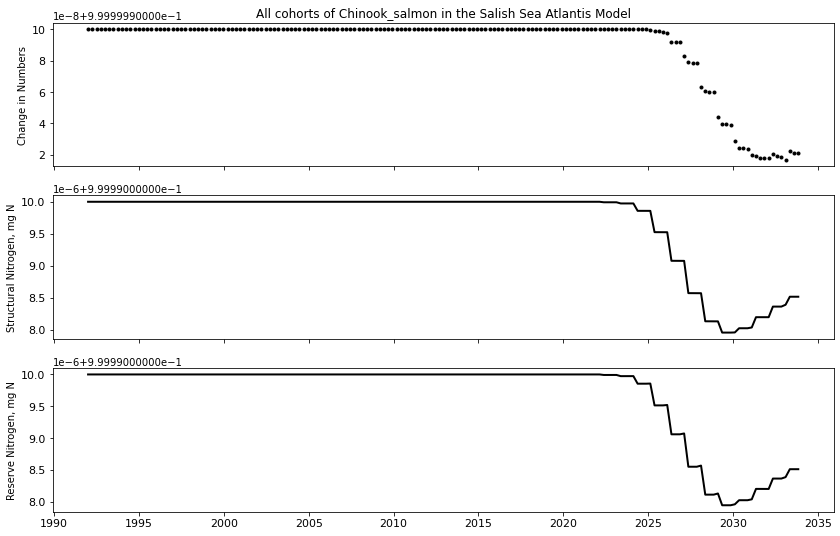

In [13]:
# Plotting biomass and size changes across aged cohorts

species_name = 'Chinook_salmon'
biomass, maturity, appetite = parse_cohorts_biomass_size(scenario, control, species_name) # maturity = structural_N, #appetite = reserved_N

# Summed across all boxes
fig, ax = plt.subplots(3,1, figsize = (14,9), sharex='all')
ax[0].plot(time, biomass, 'k.',linewidth = line_width)
ax[0].set_title('All cohorts of ' + species_name + ' in the Salish Sea Atlantis Model', fontsize = font_size)
ax[0].set_ylabel('Change in Numbers')
ax[0].tick_params(labelsize=label_size)

ax[1].plot(time, maturity, 'k',linewidth = line_width)
ax[1].set_ylabel('Structural Nitrogen, mg N')
ax[1].tick_params(labelsize=label_size)

ax[2].plot(time, appetite, 'k',linewidth = line_width)
ax[2].set_ylabel('Reserve Nitrogen, mg N')
ax[2].tick_params(labelsize=label_size)

Exploring individual cohorts

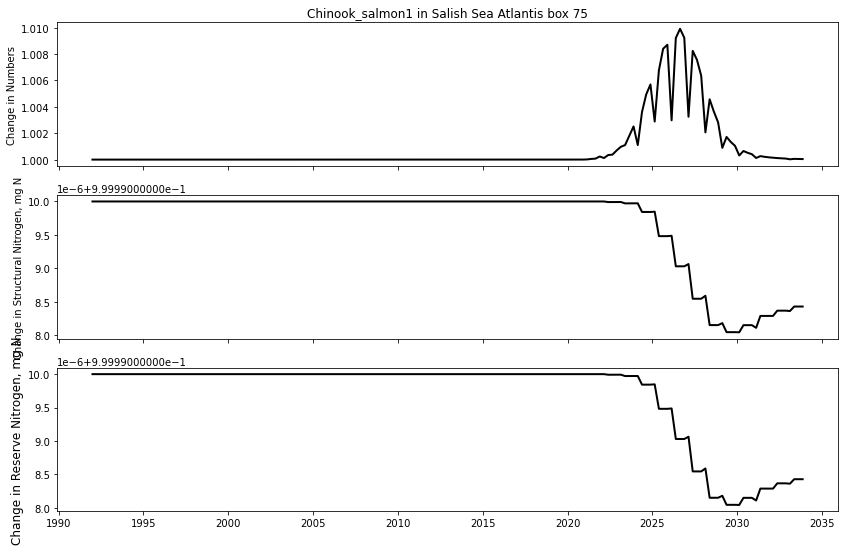

In [29]:
## Use this if you want to explore a specific cohort/species in a specific box

species = 'Chinook_salmon1'
box = 75

oiled_box_num, control_box_num = total_perbox(scenario, control, species+'_Nums', box)
oiled_box_sN, control_box_sN = total_perbox(scenario, control, species+'_StructN', box)
oiled_box_rN, control_box_rN = total_perbox(scenario, control, species+'_ResN', box)

fig, ax = plt.subplots(3,1, figsize = (14,9), sharex='all')
ax[0].plot(time, (oiled_box_num / control_box_num), 'k',linewidth = 2)
ax[0].set_title(species + ' in Salish Sea Atlantis box ' + str(box), fontsize = 12)
ax[0].set_ylabel('Change in Numbers')
ax[0].tick_params(labelsize=10)

ax[1].plot(time, (oiled_box_sN / control_box_sN), 'k',linewidth = 2)
ax[1].set_ylabel('Change in Structural Nitrogen, mg N')
ax[1].tick_params(labelsize=10)

ax[2].plot(time, (oiled_box_rN / control_box_rN), 'k',linewidth = 2)
ax[2].set_ylabel('Change in Reserve Nitrogen, mg N', fontsize = 12)
ax[2].tick_params(labelsize=10);

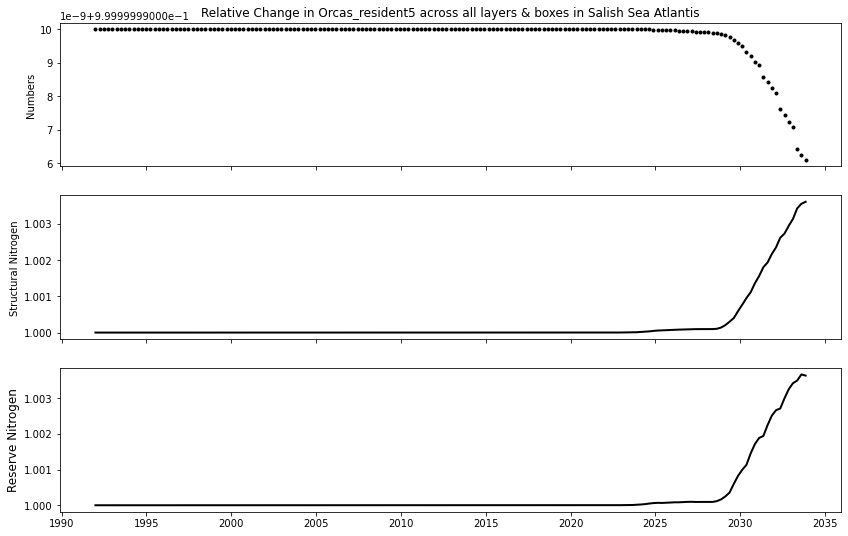

In [33]:
## Use this if you want to explore a specific cohort across all boxes and layers

species_cohort = 'Orcas_resident5'

data_num, control_num = total_boxeslayers(scenario, control, species_cohort + '_Nums')
data_sN, control_sN = total_boxeslayers(scenario, control, species_cohort +'_StructN')
data_rN, control_rN = total_boxeslayers(scenario, control, species_cohort +'_ResN')

fig, ax = plt.subplots(3,1, figsize = (14,9), sharex='all')
ax[0].plot(time, (data_num / control_num), 'k.',linewidth = 2)
ax[0].set_title('Relative Change in ' + species_cohort + ' across all layers & boxes in Salish Sea Atlantis', fontsize = 12)
ax[0].set_ylabel('Numbers')
ax[0].tick_params(labelsize=10)

ax[1].plot(time, data_sN / control_sN, 'k',linewidth = 2)
ax[1].set_ylabel('Structural Nitrogen')
ax[1].tick_params(labelsize=10)

ax[2].plot(time, data_rN / control_rN, 'k',linewidth = 2)
ax[2].set_ylabel('Reserve Nitrogen', fontsize = 12);
ax[2].tick_params(labelsize=10)

### Benthic species without age structure
benthic species: Macroalgae, Benthic_grazer, Bivalves, Crabs, Dungeness_crabs, Filter_feeder, Macrobenthos, Seagrass, Sponges

In [38]:


def plot_benthic_timeseries(scenario, control, species):
    benthic_oiled = np.ma.filled(scenario.variables[species + '_N'], np.nan) # tonnes
    benthic_control = np.ma.filled(control.variables[species + '_N'], np.nan)

    benthic = benthic_oiled.sum(axis=1) / benthic_control.sum(axis=1) 

    fig, ax = plt.subplots(figsize = (14,3)) 
    ax.plot(time, benthic, 'k.', linewidth = 2)
    ax.set_title('Relative Change in ' + species + ' across all boxes in Salish Sea Atlantis', fontsize = font_size)
    ax.set_ylabel('biomass') 
    ax.tick_params(labelsize=label_size)

    return fig, ax

In [39]:
def plot_benthic_timeseries_perbox(data, control, species, box):
    benthic_oiled = np.ma.filled(data.variables[species + '_N'][:,box], np.nan) # tonnes
    benthic_control = np.ma.filled(control.variables[species + '_N'][:,box], np.nan)

    benthic = benthic_oiled / benthic_control

    fig, ax = plt.subplots(figsize = (14,3))
    ax.plot(time, benthic, 'k.',linewidth = 2)
    ax.set_title('Relative Change in ' + species + ' in Salish Sea Atlantis box ' + str(box), fontsize = font_size)
    ax.set_ylabel('biomass') 
    ax.tick_params(labelsize=label_size)

    return fig, ax

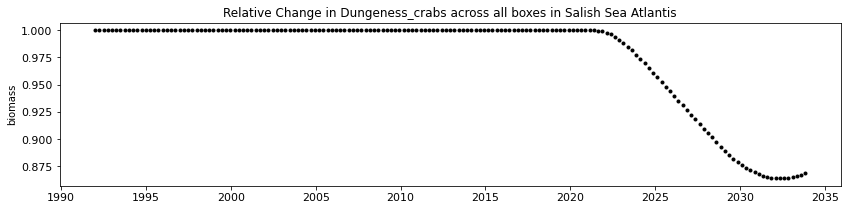

In [40]:
# Across the whole model
species = 'Dungeness_crabs'
plot_benthic_timeseries(scenario, control, species);

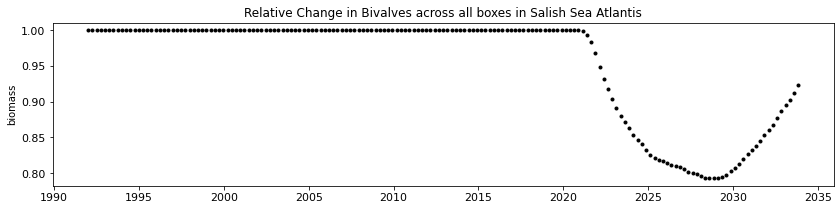

In [41]:
# Across the whole model
species = 'Bivalves'
plot_benthic_timeseries(scenario, control, species);

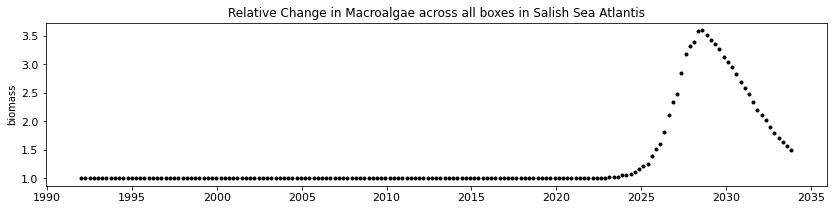

In [42]:
# Across the whole model
species = 'Macroalgae'
plot_benthic_timeseries(scenario, control, species);

/tmp/ipykernel_3245686/1508309574.py:5: RuntimeWarning: invalid value encountered in true_divide
  benthic = benthic_oiled / benthic_control


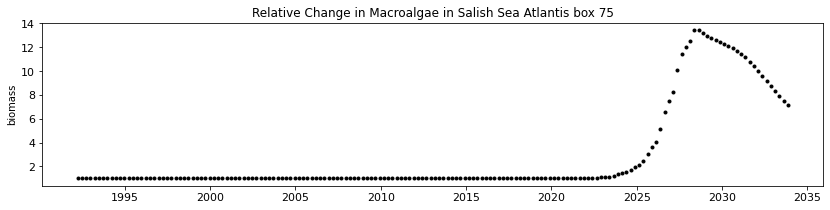

In [43]:
# Within a specific box
species = 'Macroalgae'
box = 75
plot_benthic_timeseries_perbox(scenario, control, species, box);

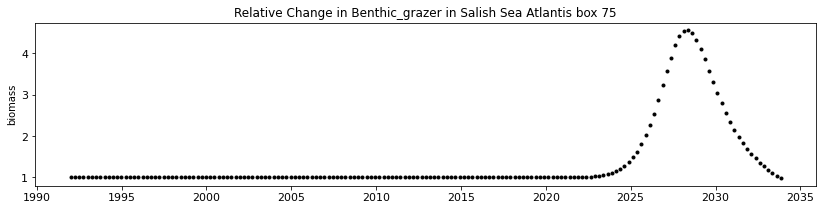

In [45]:
species = 'Benthic_grazer'
box = 75
plot_benthic_timeseries_perbox(scenario, control, species, box);